This notebook picks a bunch of healpix pixels, and places a mock cluster at the center of each

And adds shear to background objects

In [30]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp

import multiprocessing as mp

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render

In [23]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [2]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

In [3]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])

In [4]:
pixel_id = 0

In [6]:
alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

In [72]:
pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

# This is the pre injection canvas

In [73]:
pixel_scale = 0.264
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = table["ra"]
mock_catalog["DEC"] = table["dec"]
mock_catalog["X"] = (table["ra"] - ra_cen) * 60 * 60 / pixel_scale + 2499.5
mock_catalog["Y"] = (table["dec"] - dec_cen) * 60 * 60 / pixel_scale + 2499.5

mock_catalog["MAG_I"] = table["mag_i"]
mock_catalog["TSIZE"] = table["size_true"]
mock_catalog["FRACDEV"] = 0
mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
mock_catalog["G1"] = table["ellipticity_1_true"]
mock_catalog["G2"] = table["ellipticity_2_true"]

In [74]:
mock_catalog["X"].min(), mock_catalog["X"].max()
mock_catalog["Y"].min(), mock_catalog["Y"].max()

(181.51751421921654, 4817.576482395687)

In [75]:
table["ellipticity_1_true"]

5          -0.056183
10          0.162750
40          0.009457
48         -0.285715
62         -0.089482
              ...   
16568781    0.029729
16575471    0.009299
16589159    0.001880
16596437   -0.006149
16610321   -0.004273
Name: ellipticity_1_true, Length: 13632, dtype: float64

In [76]:
table.columns

Index(['redshift_true', 'mag_g', 'halo_id', 'Mag_true_i_lsst_z0', 'dec',
       'shear_1', 'ellipticity_1_true', 'Mag_true_z_lsst_z0',
       'Mag_true_r_lsst_z0', 'mag_r', 'size_true', 'ellipticity_2_true',
       'Mag_true_g_lsst_z0', 'stellar_mass', 'mag_i', 'shear_2', 'is_central',
       'ra', 'mag_z', 'halo_mass', 'galaxy_id'],
      dtype='object')

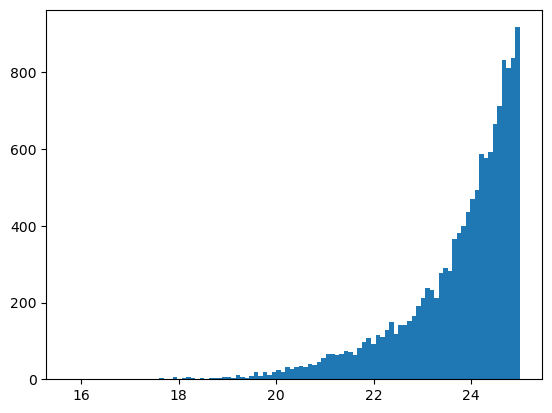

In [77]:
plt.hist(table['mag_i'], bins=100)
None

In [78]:
len(table) / (0.1 * 60)**2.

378.6666666666667

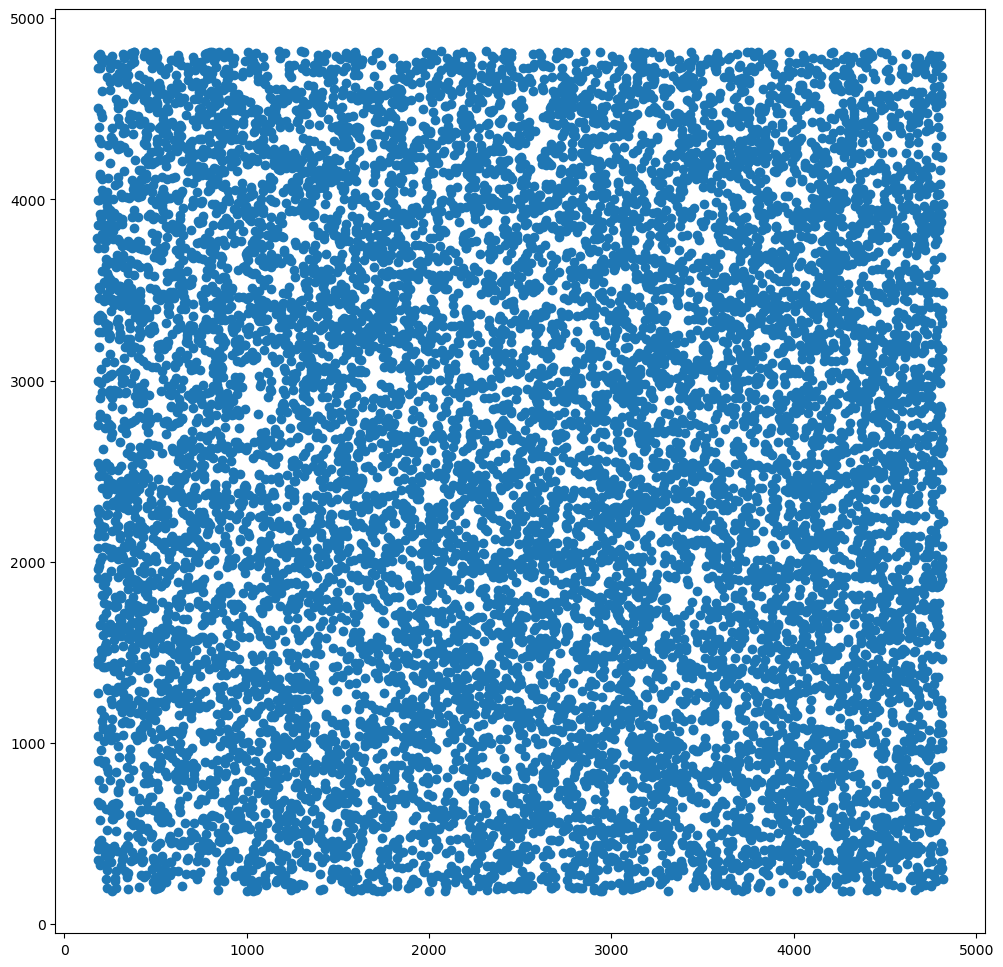

In [79]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [80]:
reload(frame)

<module 'synthetic.render.frame' from '/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/frame.py'>

In [81]:
name = 'test_canvas_grid'
print(name)
fr = frame.Frame(mock_catalog.to_records(), name=name, center=(ra_cen, dec_cen), noise_std=1, canvas_size=5000)
fr.render()
# fr.extract()

test_canvas_grid
starting xshear calculations in 100 processes


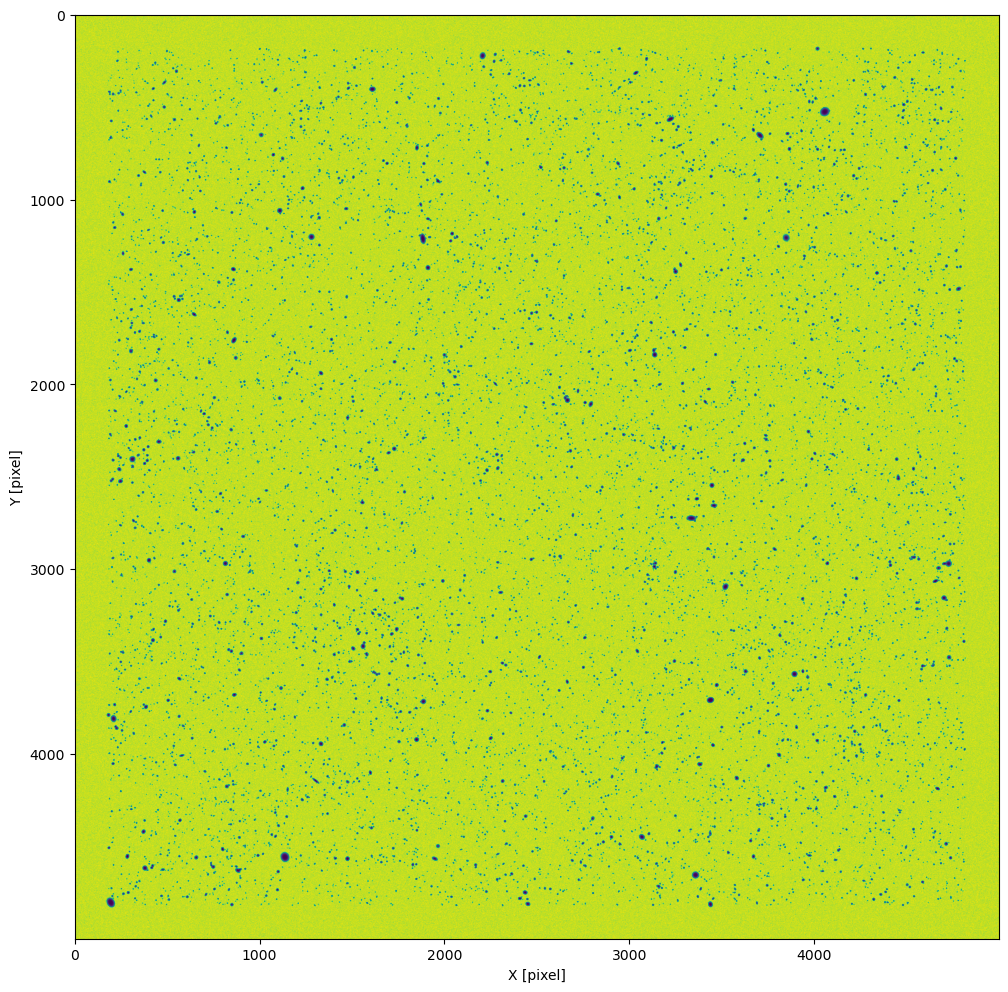

In [84]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr)
ax.set_xlabel("X [pixel]")
ax.set_ylabel("Y [pixel]")

fig.savefig("DC2_noinject_render.png")